# Energy imbalance in the ocean
Andrew Delman. Updated 2025-04-30.

This tutorial covers the ocean's role in the Earth's energy imbalance, as depicted in the ECCO state estimate. The two ECCO releases v4r4 and v4r5 are analyzed and compared.

## Objectives

- Quantify the ocean heat content (OHC) change
- Quantify heat fluxes entering the ocean through the surface, as well as the geothermal flux
- Compute time mean and trends in OHC change and heat fluxes, and consider implications for the ocean's energy imbalance

## Introduction

The [Earth's energy imbalance (EEI)](https://wmo.int/media/news/new-study-shows-earth-energy-imbalance) is a key indicator of changes in Earth's air temperature and climate. The atmospheric temperature change is the net flux of radiative energy through the top of the atmosphere, minus the heat fluxes to the oceans, land, and cryosphere (ice). Of the heat stored as a result of EEI, one recent study [(von Schuckmann et al. 2023)](https://essd.copernicus.org/articles/15/1675/2023/) estimated that ~89% has accumulated in the oceans. Therefore closing the Earth's energy budget requires an accurate estimate heat storage in the ocean, and how much of that storage is the result of fluxes atmosphere->ocean vs. from other sources.

There are two ways to estimate the ocean's energy imbalance from observations: (1) by observing the temperature change in the ocean directly, and (2) by observing the fluxes of heat into the ocean. Since the uncertainties of the data products are significant relative to the signal of the energy imbalance itself, being able to use both methods is important for constraining estimates of energy imbalance and lowering uncertainties.

## Ocean heat content change

First, let's quantify the OHC change using ECCO. Note that these computations are an abbreviated version of this ECCO [heat budget tutorial](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Heat_budget_closure.html). In this case we do not quantify heat advection and diffusion within the ocean, since we are only concerned with the global OHC change, rather than heat redistribution within the ocean.

The code below computes the total temperature tendency in the ocean (vertical mean), as well as the contribution of "forcing" to the tendency. In this case "forcing" is the heat flux through the ocean surface from the atmosphere and sea-ice, as well as the geothermal flux through the ocean floor.

In [1]:
%pdb on

# import needed packages
import numpy as np
import xarray as xr
import dask.array
import glob
import matplotlib.pyplot as plt
import requests

from os.path import expanduser,join,exists
import sys
user_home_dir = expanduser('~')
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea



def geoflx_retrieve(ecco_grid,geoflx_dir=join(user_home_dir,'Downloads')):
    """Retrieve geothermal flux data and load into workspace"""
    
    # Make copy of hFacC
    mskC = ecco_grid.hFacC.copy(deep=True).compute()
    
    # Change all fractions (ocean) to 1. land = 0
    mskC.values[mskC.values>0] = 1

    geoflx_filename = join(geoflx_dir,'geothermalFlux.bin')
    if ~exists(geoflx_filename):
        # Load the geothermal heat flux using the routine 'read_llc_to_tiles'.
        r = requests.get(\
                'https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/raw/refs/heads/master/misc/geothermalFlux.bin')
    
        # save geothermal flux to file in local directory geoflx_dir
        geoflx_filename = join(geoflx_dir,'geothermalFlux.bin')
        with open(geoflx_filename,'wb') as f:
            for chunk in r.iter_content(chunk_size=1024):
                f.write(chunk)
    
    
    geoflx = ecco.read_llc_to_tiles(geoflx_dir, 'geothermalFlux.bin')
    # Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
    geoflx_llc = xr.DataArray(geoflx,coords={'tile': ecco_grid.tile.values,
                                             'j': ecco_grid.j.values,
                                             'i': ecco_grid.i.values})
    # Create 3d bathymetry mask
    mskC_shifted = mskC.shift(k=-1)
    
    mskC_shifted.values[-1,:,:,:] = 0
    mskb = mskC - mskC_shifted
    
    # Create 3d field of geothermal heat flux
    geoflx3d = geoflx_llc * mskb.transpose('k','tile','j','i')
    GEOFLX = geoflx3d.transpose('k','tile','j','i')
    GEOFLX.attrs = {'standard_name': 'GEOFLX','long_name': 'Geothermal heat flux','units': 'W/m^2'}

    return GEOFLX
    

def temp_tend_forcing_vertmean_compute(version='v4r4',StartDate='1992-01',EndDate='2017-12'):
    """Compute vertical mean of total temperature tendency
       and forcing (surface flux & geothermal) contribution.
       Computation can be done with v4r4 or v4r5 output;
       v4r4 temperature tendency is computed using snapshots at month boundaries, 
       while v4r5 temperature tendency is computed using interpolation
       from monthly mean data."""

    # Seawater density (kg/m^3)
    rhoconst = 1029
    ## needed to convert surface mass fluxes to volume fluxes
    
    # Heat capacity (J/kg/K)
    c_p = 3994
    
    # Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
    R = 0.62
    zeta1 = 0.6
    zeta2 = 20.0
    
    
    # ShortNames
    if version == 'v4r4':
        
        ## access datasets needed for this tutorial
        
        ShortNames_list = ["ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                           "ECCO_L4_FRESH_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                           "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4",\
                           "ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4",\
                           "ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4"]
        
        access_mode = 's3_open_fsspec'
        # for access_mode = 's3_open_fsspec', need to specify the root directory 
        # containing the jsons
        jsons_root_dir = join('/efs_ecco','mzz-jsons')
        
    elif version == 'v4r5':
        ShortNames_list = ["ECCO_L4_OCEAN_AND_ICE_SURFACE_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_OCEAN_AND_ICE_SURFACE_FW_FLUX_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_OCEAN_TEMPERATURE_SALINITY_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_SEA_SURFACE_HEIGHT_LLC0090GRID_MONTHLY_V4R5"]
    
        access_mode = 's3_open'
        jsons_root_dir = None
        
    
    # load grid parameters
    if version == 'v4r4':
        ecco_grid = ea.ecco_podaac_to_xrdataset("ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                                  version='v4r4',\
                                                  mode=access_mode,\
                                                  jsons_root_dir=jsons_root_dir)
    elif version == 'v4r5':
        ecco_grid = xr.open_dataset('/efs_ecco/ECCO/V4/r5/grid/nctiles_grid/ECCO-GRID.nc')
    ecco_grid = ecco_grid.compute()
    
    
    ds_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                                StartDate=StartDate,EndDate=EndDate,\
                                                version=version,\
                                                snapshot_interval='monthly',\
                                                mode=access_mode,\
                                                jsons_root_dir=jsons_root_dir,\
                                                show_noredownload_msg=False,\
                                                prompt_request_payer=False)
    
    
    # Volume (m^3)
    vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i').compute()
    
    year_start = np.int64(StartDate[:4])
    year_end = np.int64(EndDate[:4])

    if version == 'v4r4':
        # open ETAN and THETA snapshots (beginning of each month)
        ecco_monthly_SSH = ds_dict[ShortNames_list[-2]]
        ecco_monthly_TS = ds_dict[ShortNames_list[-1]]
        ecco_monthly_snaps = xr.merge((ecco_monthly_SSH['ETAN'],ecco_monthly_TS['THETA']))
    elif version == 'v4r5':
        # we don't have SSH and temp snapshots, so estimate based on interpolation
        ecco_monthly_ETAN = ds_dict[ShortNames_list[3]]['ETAN'].transpose('time','tile','j','i').data
        ecco_monthly_THETA = ds_dict[ShortNames_list[2]]['THETA'].transpose('time','k','tile','j','i').data
        time_bnds = ds_dict[ShortNames_list[3]].time_bnds.isel(time=slice(0,-1),nv=1).data
        ETAN_interp = ecco_monthly_ETAN[:-1,:,:,:] + (np.diff(ecco_monthly_ETAN,axis=0)/2)
        THETA_interp = ecco_monthly_THETA[:-1,:,:,:,:] + (np.diff(ecco_monthly_THETA,axis=0)/2)
        
        ecco_monthly_snaps = xr.Dataset(coords={**{'time':time_bnds},**ecco_grid[['Z','XC','YC']]},\
                                        data_vars={'ETAN':(['time','tile','j','i'],ETAN_interp),\
                                                   'THETA':(['time','k','tile','j','i'],THETA_interp)}\
                                       )
        
    # time mask for snapshots
    time_snap_mask = np.logical_and(ecco_monthly_snaps.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                    ecco_monthly_snaps.time.values < np.datetime64(str(year_end+1)+'-01-02','ns'))
    
    ecco_monthly_snaps = ecco_monthly_snaps.isel(time=time_snap_mask)
    
    ## Consolidate ECCO monthly mean variables needed into one dataset
    
    ecco_vars_sfc = ds_dict[ShortNames_list[0]]
    ecco_vars_sfcFW = ds_dict[ShortNames_list[1]]
    ecco_vars_TS = ds_dict[ShortNames_list[2]]
    
    ecco_monthly_mean = xr.merge((ecco_vars_sfc[['TFLUX','oceQsw','oceQnet']],\
                                  ecco_vars_sfcFW['oceFWflx'],\
                                  ecco_vars_TS['THETA']))
    
    # time mask for monthly means
    time_mean_mask = np.logical_and(ecco_monthly_mean.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                    ecco_monthly_mean.time.values < np.datetime64(str(year_end+1)+'-01-01','ns'))
    
    ecco_monthly_mean = ecco_monthly_mean.isel(time=time_mean_mask)
    
    
    # Drop superfluous coordinates (We already have them in ecco_grid)
    ecco_monthly_mean = ecco_monthly_mean.reset_coords(drop=True)

    # pad time axis of snapshot dataset as needed
    if ecco_monthly_snaps.sizes['time'] <= ecco_monthly_mean.sizes['time']:
        n_pad_end = ecco_monthly_mean.sizes['time'] - ecco_monthly_snaps.sizes['time']
        ecco_monthly_snaps = ecco_monthly_snaps.pad(pad_width={'time':(1,n_pad_end)},mode='constant',\
                                                    constant_values=np.nan)

    # merge all datasets into one
    ds = xr.merge([ecco_monthly_mean,\
                   ecco_monthly_snaps.rename({'time':'time_snp','ETAN':'ETAN_snp', 'THETA':'THETA_snp'}),\
                   ecco_grid[['hFacC','drF','rA']]])
    
    # Change time axis of the snapshot variables
    ds.time_snp.attrs['c_grid_axis_shift'] = 0.5
    
    # get LLC grid object
    grid = ecco.get_llc_grid(ds)
    
    
    
    ## compute vertical mean temperature tendency
    
    delta_t = xr.DataArray(np.diff(ds.time_snp.data),coords={'time':ds.time})
    
    # Convert to seconds
    delta_t = delta_t.astype('f4') / 1e9
    
    
    # Calculate the s*theta term
    sTHETA = ds.THETA_snp*(1+ds.ETAN_snp/ecco_grid.Depth)
    
    
    # Total tendency (psu/s)
    G_total = sTHETA.diff(dim='time_snp')/np.expand_dims(delta_t.values,axis=(1,2,3,4))
    
    # re-assign and rename time coordinate
    G_total = G_total.rename({'time_snp':'time'})
    G_total = G_total.assign_coords({'time':delta_t.time.values})

    # vertical mean of G_total
    depth_int_masked = (ds.hFacC*ds.drF).compute()
    
    G_total_vertmean = (((depth_int_masked*G_total).sum('k'))/\
                          (depth_int_masked.sum('k')))\
                            .transpose('time','tile','j','i').compute()
    G_total_vertmean = G_total_vertmean.where(np.abs(G_total_vertmean) > 1.e-16,np.nan)
    
    
    # The weights are just the number of seconds per month divided by total seconds
    month_length_weights = delta_t / delta_t.sum()    

    print('Total temp tend computed,',version)

    
    ## compute forcing flux
    def forcH_compute(ds,ecco_grid):
        
        Z = ecco_grid.Z.compute()
        RF = np.concatenate([ecco_grid.Zp1.values[:-1],[np.nan]])
        
        q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
        q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])
        
        # Correction for the 200m cutoff
        zCut = np.where(Z < -200)[0][0]
        q1[zCut:] = 0
        q2[zCut-1:] = 0
        
        # Create xarray data arrays
        q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
        q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])
        
        ## Land masks
        # Make copy of hFacC
        mskC = ecco_grid.hFacC.copy(deep=True).compute()
        
        # Change all fractions (ocean) to 1. land = 0
        mskC.values[mskC.values>0] = 1
        
        # Shortwave flux below the surface (W/m^2)
        oceQsw = ds.oceQsw.compute()
        forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw).transpose('time','k','tile','j','i')
        
        # Surface heat flux (W/m^2)
        forcH_surf = ((ds.TFLUX.compute() - (1-(q1[0]-q2[0]))*oceQsw)\
                      *mskC[0]).transpose('time','tile','j','i').assign_coords(k=0).expand_dims('k')
        
        # Full-depth sea surface forcing (W/m^2)
        forcH = xr.concat([forcH_surf,forcH_subsurf.isel(k=slice(1,None))],dim='k').transpose('time','k','tile','j','i')
                
        return forcH
    
    
    ## vertical mean of forcing tendency    
    
    # Load the geothermal heat flux
    GEOFLX = geoflx_retrieve(ecco_grid)

    
    # compute in chunks in order to limit memory usage

    depth_int_masked = (ds.hFacC*ds.drF).compute()
    
    G_forcing_vertmean_array = np.empty(G_total_vertmean.shape)
    G_forcing_vertmean_array.fill(np.nan)
    t_chunksize = 24
    for chunk in range(0,int(np.ceil(ds.sizes['time']/t_chunksize))):
        curr_t = slice(chunk*t_chunksize,np.fmin((chunk+1)*t_chunksize,ds.sizes['time']))
        # compute surface (and subsurface shortwave) forcing flux
        curr_forcH = forcH_compute(ds.isel(time=curr_t),ecco_grid)
        
        # Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
        curr_G_forcing = ((curr_forcH + GEOFLX)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)

        # depth average
        G_forcing_vertmean_array[curr_t,:,:,:] = (((depth_int_masked*curr_G_forcing).sum('k'))/\
                                                      (depth_int_masked.sum('k')))\
                                                        .transpose('time','tile','j','i').values
    G_forcing_vertmean = xr.DataArray(G_forcing_vertmean_array,dims=['time','tile','j','i'])   

    print('Forcing temp tend computed,',version)

    
    return G_total_vertmean,G_forcing_vertmean,ds


G_total_vertmean_v4r4,G_forcing_vertmean_v4r4,ds_v4r4 = \
                        temp_tend_forcing_vertmean_compute(version='v4r4',\
                                                  StartDate='1992-01',EndDate='2017-12')

G_total_vertmean_v4r5,G_forcing_vertmean_v4r5,ds_v4r5 = \
                        temp_tend_forcing_vertmean_compute(version='v4r5',\
                                                  StartDate='1992-01',EndDate='2019-12')

Automatic pdb calling has been turned ON

Total number of matching granules: 336

Total number of matching granules: 336

Total number of matching granules: 336

Total number of matching granules: 336


/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Total temp tend computed, v4r5
load_binary_array: loading file /home/jovyan/Downloads/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


NameError: name 'forcH' is not defined

> /tmp/ipykernel_3645/3808394337.py(290)temp_tend_forcing_vertmean_compute()
    288 
    289         # Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
--> 290         curr_G_forcing = ((forcH + GEOFLX)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)
    291 
    292         # depth average



ipdb>  curr_G_forcing = ((curr_forcH + GEOFLX)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)
ipdb>  G_forcing_vertmean_array[curr_t,:,:,:] = (((depth_int_masked*curr_G_forcing).sum('k'))/(depth_int_masked.sum('k'))).transpose('time','tile','j','i').values
ipdb>  exit()


Having computed the vertical mean, we then compute the global volumetric mean of the total tendency and the forcing contribution. The global mean is obtained from the vertical means by horizontally averaging, with the area*depth of the water column as weights.

In [2]:
access_mode = 's3_open_fsspec'
jsons_root_dir = join(user_home_dir,'mzz_jsons')
ecco_grid_v4r4 = ea.ecco_podaac_to_xrdataset("ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                                  version='v4r4',\
                                                  mode=access_mode,\
                                                  jsons_root_dir=jsons_root_dir)
ocean_vol_weights_v4r4 = (ecco_grid_v4r4.hFacC*ecco_grid_v4r4.rA*ecco_grid_v4r4.drF).sum('k').compute()
ocean_vol_v4r4 = (ecco_grid_v4r4.hFacC*ecco_grid_v4r4.rA*ecco_grid_v4r4.drF).sum(['tile','k','j','i']).compute()

download_root_dir = join(user_home_dir,'ECCO','v4r5')
ecco_grid_v4r5 = xr.open_mfdataset(join(download_root_dir,'grid_ECCOV4r5',\
                                     'GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'))
ocean_vol_weights_v4r5 = (ecco_grid_v4r5.hFacC*ecco_grid_v4r5.rA*ecco_grid_v4r5.drF).sum('k').compute()
ocean_vol_v4r5 = (ecco_grid_v4r5.hFacC*ecco_grid_v4r5.rA*ecco_grid_v4r5.drF).sum(['tile','k','j','i']).compute()


def tend_terms_globmean_compute(G_forcing_vertmean,G_total_vertmean,\
                                ocean_vol_weights,ocean_vol):

    G_forcing_globmean = ((ocean_vol_weights*G_forcing_vertmean).sum(['tile','j','i'])\
                                /ocean_vol).compute()
    G_total_globmean = ((ocean_vol_weights*G_total_vertmean).sum(['tile','j','i'])\
                                /ocean_vol).compute()

    return G_forcing_globmean,G_total_globmean

G_forcing_globmean_v4r4,G_total_globmean_v4r4 = \
                                        tend_terms_globmean_compute(G_forcing_vertmean_v4r4,\
                                                                    G_total_vertmean_v4r4,\
                                                                    ocean_vol_weights_v4r4,ocean_vol_v4r4)

G_forcing_globmean_v4r5,G_total_globmean_v4r5 = \
                                        tend_terms_globmean_compute(G_forcing_vertmean_v4r5,\
                                                                    G_total_vertmean_v4r5,\
                                                                    ocean_vol_weights_v4r5,ocean_vol_v4r5)

Now let's check that the "forcing" (surface flux + geothermal) contribution explains the global mean heating of the ocean. For these plots, let's convert the units from temperature tendency (useful in budget calculations) to rate of ocean heat content change. To do this we multiply the temperature tendency by the volume of the ocean, density (rhoConst), and heat capacity (c_p) to obtain rate of global ocean heat change. You can track how these multiplications change the units from $^{\circ}$C s$^{-1}$ to J $s^{-1}$, also known as Watts or W:

- (C s$^{-1}$) * (m$^3$)(kg m$^{-3}$)(J kg$^{-1}$ C$^{-1}$) = J s$^{-1}$ = W

In [ ]:
rhoConst = 1029
c_p = 3994


OHC_change_forcing_globmean_v4r4 = (ocean_vol_v4r4*rhoConst*c_p*G_forcing_globmean_v4r4)
OHC_change_total_globmean_v4r4 = (ocean_vol_v4r4*rhoConst*c_p*G_total_globmean_v4r4)
# mask out zero values
OHC_change_total_globmean_v4r4 = OHC_change_total_globmean_v4r4\
                                    .where(np.abs(OHC_change_total_globmean_v4r4) > 1.e-3,np.nan)

OHC_change_forcing_globmean_v4r5 = (ocean_vol_v4r5*rhoConst*c_p*G_forcing_globmean_v4r5)
OHC_change_total_globmean_v4r5 = (ocean_vol_v4r5*rhoConst*c_p*G_total_globmean_v4r5)
# mask out zero values
OHC_change_total_globmean_v4r5 = OHC_change_total_globmean_v4r5\
                                    .where(np.abs(OHC_change_total_globmean_v4r5) > 1.e-10,np.nan)

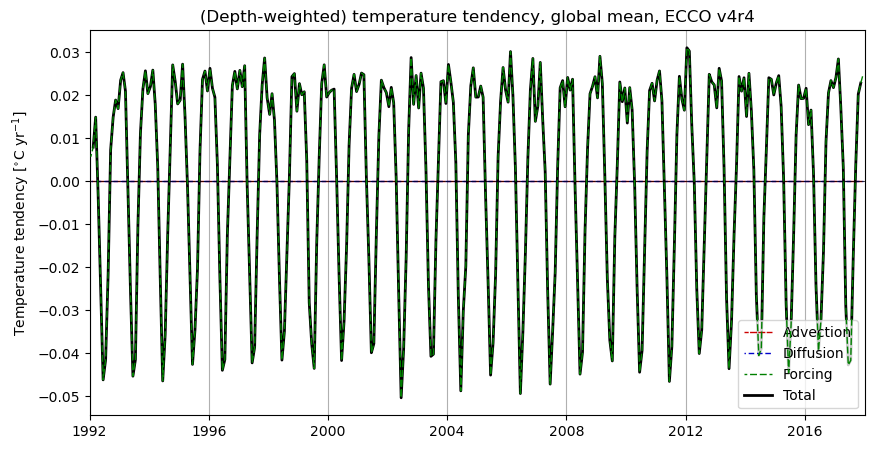

In [ ]:
# plot OHC rate of change, v4r4
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(ds_v4r4.time.values,OHC_change_forcing_globmean_v4r4.values,\
        color=(.8,.6,0),linewidth=1,linestyle=(3,(5,2)),zorder=10,label='Forcing')
ax.plot(ds_v4r4.time.values,OHC_change_total_globmean_v4r4.values,\
        color=(0,0,0),linewidth=2,label='Total')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('OHC rate of change [W]')
ax.set_title('Global ocean heat content rate of change, ECCO v4r4')
plt.legend()
plt.show()

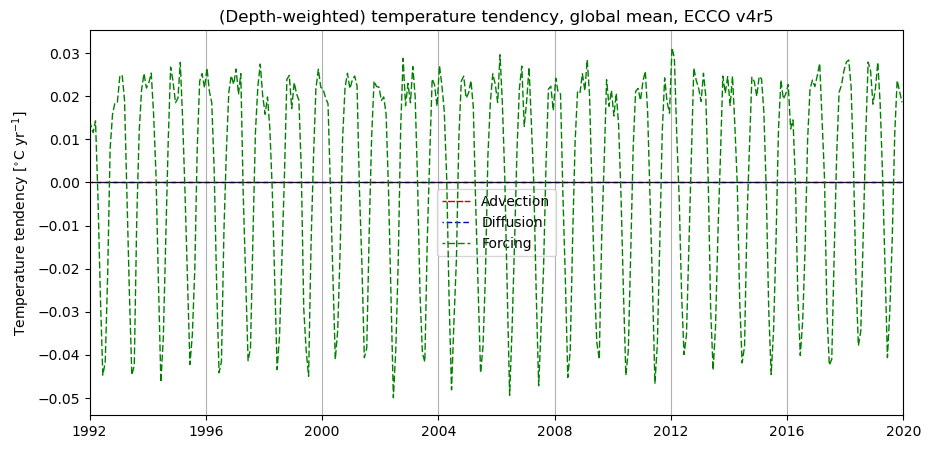

In [80]:
# plot OHC rate of change, v4r5
fig,ax = plt.subplots(1,1,figsize=(10.5,5))
ax.plot(ds_v4r5.time.values,OHC_change_forcing_globmean_v4r5.values,\
        color=(.8,.6,0),linewidth=1,linestyle=(3,(5,2)),zorder=10,label='Forcing')
ax.plot(ds_v4r5.time.values,OHC_change_total_globmean_v4r5.values,\
        color=(0,0,0),linewidth=2,label='Total')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax.set_ylabel('OHC rate of change [W]')
ax.set_title('Global ocean heat content rate of change, ECCO v4r5')
plt.legend()
plt.show()

Note that if the above time series are divided by surface area (either the ocean surface area or the Earth's surface area), we would get an effective heat flux in units of W m$^{-2}$. Dividing by the Earth's surface area is the most relevant quantity for EEI studies, though dividing by the ocean surface area may be more useful for understanding the ocean-specific energy imbalance.

## Components of the heat flux into the ocean

The previous section established that heat fluxes or "forcing" explain the change in the ocean's heat content. Now let's consider the relative contributions of several different types of fluxes. The types that you are probably most familiar with are:

- Radiative fluxes (shortwave + longwave)
- Turbulent fluxes (latent + sensible)

The ECCO variable that contains all of these fluxes into the ocean (from the atmosphere and sea-ice) is `oceQnet`. However, for completeness, we need to consider additional fluxes of heat that are not discussed nearly as much by oceanographers, and which many ocean models neglect:

One is the heat flux associated with the surface freshwater flux--i.e., from the temperature difference between the water removed from the ocean via evaporation vs. the water restored to the ocean via precipitation and runoff. (Note that this is different from the latent heat flux, which is also associated with evaporation but is the heating associated with the phase change of the water, not the temperature change.) There is no ECCO variable that quantifies this flux specifically, but the variable `TFLUX` includes the temperature impact of mass fluxes. Hence the difference `TFLUX` - `oceQnet` should reflect the impact of this flux, and this is demonstrated below.

The other heat flux is the geothermal flux, which of course does not occur across the ocean surface but is necessary to close the ocean's heat budget. The geothermal flux is not archived in a dataset like most ECCO variables, but is included as a binary file in the ECCO ancillary output. This file has also been [archived](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/tree/master/misc) in the ECCOv4 Python tutorial Github repo, and this notebook accesses the file from there.

ECCO makes quantifying these components of the net heat flux into the ocean fairly straightforward, as you can see in the simple function below.

In [17]:
def G_forcing_components_globmean(ds):
    ocean_area_weights = ds.hFacC.isel(k=0)*ds.rA
    ocean_area_sum = ocean_area_weights.sum(['tile','j','i']).compute()
    oceQnet_globmean = ((ocean_area_weights*ds.oceQnet).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    c_p = 3994
    FWflxT = c_p*(ds.oceFWflx*(ds.THETA.isel(k=0)))
    FWflxT_globmean = ((ocean_area_weights*FWflxT).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    TFLUX_globmean = ((ocean_area_weights*ds.TFLUX).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    GEOFLX = geoflx_retrieve(ds)
    geoflx_globmean = ((ocean_area_weights*((GEOFLX.sum('k'))\
                                            *xr.DataArray(np.ones((ds.sizes['time'],)),dims=['time']))).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()

    return oceQnet_globmean,FWflxT_globmean,TFLUX_globmean,geoflx_globmean

ratio_ocean_global_area = ((ds_v4r4.hFacC.isel(k=0)*ds_v4r4.rA).sum(['tile','j','i'])\
                            /(ds_v4r4.rA.sum(['tile','j','i']))).values

oceQnet_globmean_v4r4,FWflxT_globmean_v4r4,\
    TFLUX_globmean_v4r4,geoflx_globmean_v4r4 = G_forcing_components_globmean(ds_v4r4)
oceQnet_globmean_v4r5,FWflxT_globmean_v4r5,\
    TFLUX_globmean_v4r5,geoflx_globmean_v4r5 = G_forcing_components_globmean(ds_v4r5)

load_binary_array: loading file /home/jpluser/ECCO-v4-Python-Tutorial/misc/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
load_binary_array: loading file /home/jpluser/ECCO-v4-Python-Tutorial/misc/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [62]:
t_bnds_v4r4 = np.insert(np.arange(np.datetime64('1992-02','M'),np.datetime64('2018-02','M'),np.timedelta64(1,'M'))\
                        .astype('datetime64[ns]'),\
                        0,np.datetime64('1992-01-01T12','ns'))
delta_t_v4r4 = xr.DataArray(np.diff(t_bnds_v4r4),dims=['time']).astype('f4')/1e9

# Convert to seconds
delta_t_v4r4 = delta_t_v4r4.astype('f4')

t_bnds_v4r5 = np.insert(np.arange(np.datetime64('1992-02','M'),np.datetime64('2020-02','M'),np.timedelta64(1,'M'))\
                        .astype('datetime64[ns]'),\
                        0,np.datetime64('1992-01-01T12','ns'))
delta_t_v4r5 = xr.DataArray(np.diff(t_bnds_v4r5),dims=['time']).astype('f4')/1e9

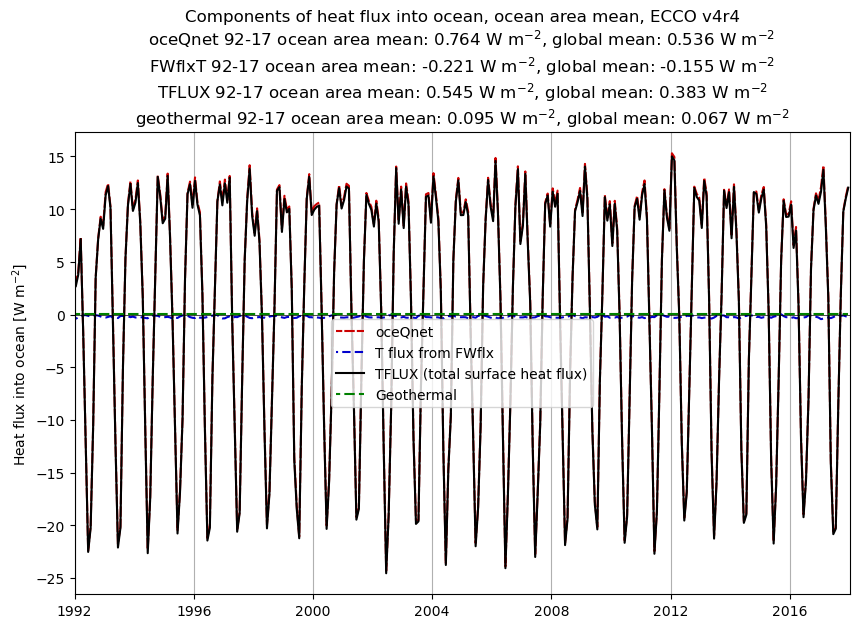

In [81]:
def weighted_tmean(array,t_weights):
    array_tmean = ((t_weights*array).sum('time')/(t_weights.sum('time'))).compute()

    return array_tmean


oceQnet_globmean_tmean_v4r4 = weighted_tmean(oceQnet_globmean_v4r4,delta_t_v4r4)
FWflxT_globmean_tmean_v4r4 = weighted_tmean(FWflxT_globmean_v4r4,delta_t_v4r4)
geoflx_globmean_tmean_v4r4 = weighted_tmean(geoflx_globmean_v4r4,delta_t_v4r4)
TFLUX_globmean_tmean_v4r4 = weighted_tmean(TFLUX_globmean_v4r4,delta_t_v4r4)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(ds_v4r4.time.values,oceQnet_globmean_v4r4.values,color=(.8,0,0),linestyle=(2,(5,1)),label='oceQnet')
ax.plot(ds_v4r4.time.values,FWflxT_globmean_v4r4.values,color=(0,0,.8),linestyle=(3,(4,2)),label='T flux from FWflx')
ax.plot(ds_v4r4.time.values,TFLUX_globmean_v4r4.values,color=(0,0,0),label='TFLUX (total surface heat flux)')
ax.plot(ds_v4r4.time.values,geoflx_globmean_v4r4.values,color=(0,.5,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Components of heat flux into ocean, ocean area mean, ECCO v4r4\n'\
             +'oceQnet 92-17 ocean area mean: '+str(.001*np.round(oceQnet_globmean_tmean_v4r4.values/.001))[:5]+' W m$^{-2}$,'\
             +' global mean: '+str(.001*np.round(ratio_ocean_global_area*oceQnet_globmean_tmean_v4r4.values/.001))+' W m$^{-2}$\n'\
             +'FWflxT 92-17 ocean area mean: '+str(.001*np.round(FWflxT_globmean_tmean_v4r4.values/.001))[:6]+' W m$^{-2}$,'\
             +' global mean: '+str(.001*np.round(ratio_ocean_global_area*FWflxT_globmean_tmean_v4r4.values/.001))+' W m$^{-2}$\n'\
             +'TFLUX 92-17 ocean area mean: '+str(.001*np.round(TFLUX_globmean_tmean_v4r4.values/.001))[:5]+' W m$^{-2}$,'\
             +' global mean: '+str(.001*np.round(ratio_ocean_global_area*TFLUX_globmean_tmean_v4r4.values/.001))[:5]+' W m$^{-2}$\n'\
             +'geothermal 92-17 ocean area mean: '+str(.001*np.round(geoflx_globmean_tmean_v4r4.values/.001))+' W m$^{-2}$,'\
             +' global mean: '+str(.001*np.round(ratio_ocean_global_area*geoflx_globmean_tmean_v4r4.values/.001))+' W m$^{-2}$')
plt.legend()
plt.savefig(join(figures_dir,'Forcing_fluxes_globmean_tseries_ECCOv4r4_1992_2017.png'))
plt.show()

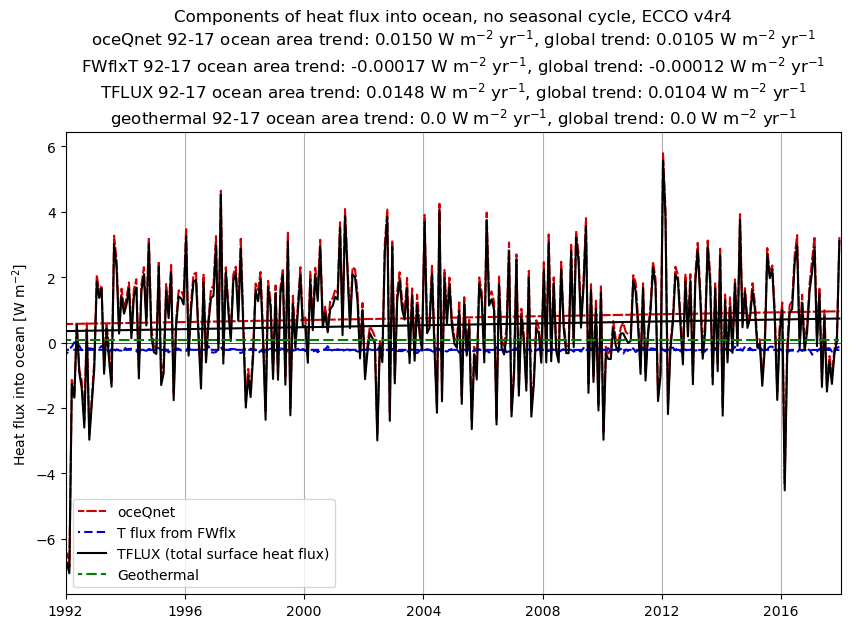

In [82]:
oceQnet_globmean_v4r4_noseas = \
            seasonal_cycle_harmonics(oceQnet_globmean_v4r4.values,ds_v4r4.time.values,num_harmonics=4)
FWflxT_globmean_v4r4_noseas = \
            seasonal_cycle_harmonics(FWflxT_globmean_v4r4.values,ds_v4r4.time.values,num_harmonics=4)
TFLUX_globmean_v4r4_noseas = \
            seasonal_cycle_harmonics(TFLUX_globmean_v4r4.values,ds_v4r4.time.values,num_harmonics=4)

# trends, computed with weights based on month length
trend_normalization = (delta_t_v4r4.sum('time')/len(delta_t_v4r4)).values
oceQnet_globmean_v4r4_trendperyr,oceQnet_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*oceQnet_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
oceQnet_globmean_v4r4_trendperyr = oceQnet_globmean_v4r4_trendperyr/trend_normalization
oceQnet_globmean_v4r4_trendline = oceQnet_globmean_v4r4_trendline/trend_normalization
FWflxT_globmean_v4r4_trendperyr,FWflxT_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*FWflxT_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
FWflxT_globmean_v4r4_trendperyr = FWflxT_globmean_v4r4_trendperyr/trend_normalization
FWflxT_globmean_v4r4_trendline = FWflxT_globmean_v4r4_trendline/trend_normalization
TFLUX_globmean_v4r4_trendperyr,TFLUX_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*TFLUX_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
TFLUX_globmean_v4r4_trendperyr = TFLUX_globmean_v4r4_trendperyr/trend_normalization
TFLUX_globmean_v4r4_trendline = TFLUX_globmean_v4r4_trendline/trend_normalization
geoflx_globmean_v4r4_trendperyr,geoflx_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*geoflx_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
geoflx_globmean_v4r4_trendperyr = geoflx_globmean_v4r4_trendperyr/trend_normalization
geoflx_globmean_v4r4_trendline = geoflx_globmean_v4r4_trendline/trend_normalization

fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
ax.plot(ds_v4r4.time.values,oceQnet_globmean_v4r4_noseas + oceQnet_globmean_tmean_v4r4.values,\
                color=(.8,0,0),linestyle=(2,(5,1)),label='oceQnet')
h, = ax.plot(ds_v4r4.time.values,oceQnet_globmean_v4r4_trendline,\
                color=(.8,0,0),linestyle=(2,(5,1)),label='oceQnet')
handles.append(h)
ax.plot(ds_v4r4.time.values,FWflxT_globmean_v4r4_noseas + FWflxT_globmean_tmean_v4r4.values,\
                color=(0,0,.8),linestyle=(3,(4,2)),label='T flux from FWflx')
h, = ax.plot(ds_v4r4.time.values,FWflxT_globmean_v4r4_trendline,\
                color=(0,0,.8),linestyle=(3,(4,2)),label='T flux from FWflx')
handles.append(h)
ax.plot(ds_v4r4.time.values,TFLUX_globmean_v4r4_noseas + TFLUX_globmean_tmean_v4r4.values,\
                color=(0,0,0),label='TFLUX (total surface heat flux)')
h, = ax.plot(ds_v4r4.time.values,TFLUX_globmean_v4r4_trendline,\
                color=(0,0,0),label='TFLUX (total surface heat flux)')
handles.append(h)
h, = ax.plot(ds_v4r4.time.values,geoflx_globmean_v4r4_trendline,\
                color=(0,.5,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Components of heat flux into ocean, no seasonal cycle, ECCO v4r4\n'\
             +'oceQnet 92-17 ocean area trend: '+str(.0001*np.round(oceQnet_globmean_v4r4_trendperyr[0]/.0001))[:6]+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.0001*np.round(ratio_ocean_global_area*oceQnet_globmean_v4r4_trendperyr[0]/.0001))+' W m$^{-2}$ yr$^{-1}$\n'\
             +'FWflxT 92-17 ocean area trend: '+str(.00001*np.round(FWflxT_globmean_v4r4_trendperyr[0]/.00001))+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.00001*np.round(ratio_ocean_global_area*FWflxT_globmean_v4r4_trendperyr[0]/.00001))[:8]\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'TFLUX 92-17 ocean area trend: '+str(.0001*np.round(TFLUX_globmean_v4r4_trendperyr[0]/.0001))+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.0001*np.round(ratio_ocean_global_area*TFLUX_globmean_v4r4_trendperyr[0]/.0001))[:6]+' W m$^{-2}$ yr$^{-1}$\n'\
             +'geothermal 92-17 ocean area trend: '+str(.0001*np.round(geoflx_globmean_v4r4_trendperyr[0]/.0001))+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.0001*np.round(ratio_ocean_global_area*geoflx_globmean_v4r4_trendperyr[0]/.0001))+' W m$^{-2}$ yr$^{-1}$')
plt.legend(handles=handles)
plt.savefig(join(figures_dir,'Forcing_fluxes_globmean_noseas_trend_ECCOv4r4_1992_2017.png'))
plt.show()

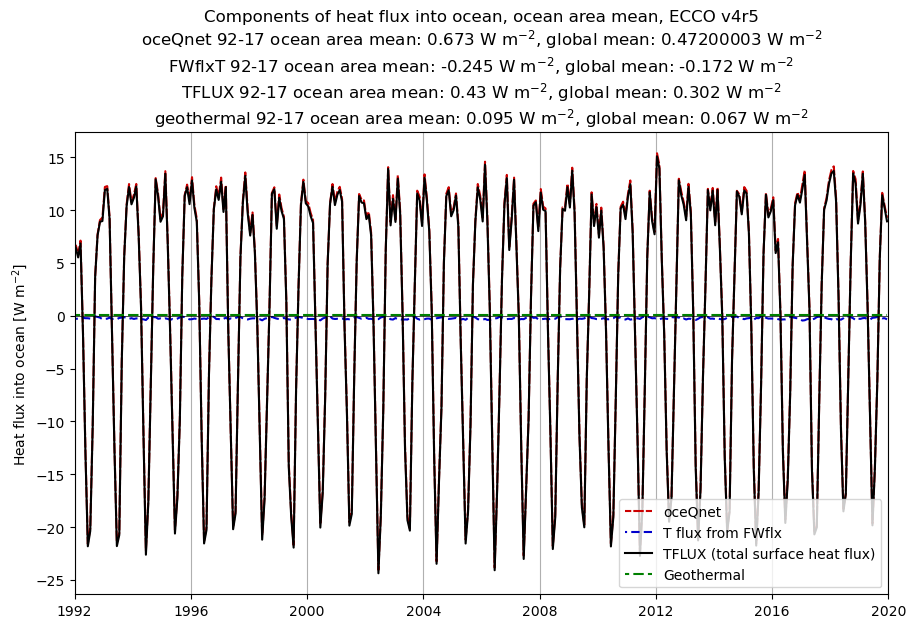

In [83]:
oceQnet_globmean_tmean = weighted_tmean(oceQnet_globmean_v4r5[:-24],delta_t_v4r5[:-24])
FWflxT_globmean_tmean = weighted_tmean(FWflxT_globmean_v4r5[:-24],delta_t_v4r5[:-24])
geoflx_globmean_tmean = weighted_tmean(geoflx_globmean_v4r5[:-24],delta_t_v4r5[:-24])
TFLUX_globmean_tmean = weighted_tmean(TFLUX_globmean_v4r5[:-24],delta_t_v4r5[:-24])

fig,ax = plt.subplots(1,1,figsize=(10.5,6))
ax.plot(ds_v4r5.time.values,oceQnet_globmean_v4r5.values,color=(.8,0,0),linestyle=(2,(5,1)),label='oceQnet')
ax.plot(ds_v4r5.time.values,FWflxT_globmean_v4r5.values,color=(0,0,.8),linestyle=(3,(4,2)),label='T flux from FWflx')
ax.plot(ds_v4r5.time.values,TFLUX_globmean_v4r5.values,color=(0,0,0),label='TFLUX (total surface heat flux)')
ax.plot(ds_v4r5.time.values,geoflx_globmean_v4r5.values,color=(0,.5,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Components of heat flux into ocean, ocean area mean, ECCO v4r5\n'\
             +'oceQnet 92-17 ocean area mean: '+str(.001*np.round(oceQnet_globmean_tmean.values/.001))[:5]+' W m$^{-2}$,'\
             +' global mean: '+str(.001*np.round(ratio_ocean_global_area*oceQnet_globmean_tmean.values/.001))+' W m$^{-2}$\n'\
             +'FWflxT 92-17 ocean area mean: '+str(.001*np.round(FWflxT_globmean_tmean.values/.001))+' W m$^{-2}$,'\
             +' global mean: '+str(.001*np.round(ratio_ocean_global_area*FWflxT_globmean_tmean.values/.001))+' W m$^{-2}$\n'\
             +'TFLUX 92-17 ocean area mean: '+str(.001*np.round(TFLUX_globmean_tmean.values/.001))[:5]+' W m$^{-2}$,'\
             +' global mean: '+str(.001*np.round(ratio_ocean_global_area*TFLUX_globmean_tmean.values/.001))[:5]+' W m$^{-2}$\n'\
             +'geothermal 92-17 ocean area mean: '+str(.001*np.round(geoflx_globmean_tmean.values/.001))+' W m$^{-2}$,'\
             +' global mean: '+str(.001*np.round(ratio_ocean_global_area*geoflx_globmean_tmean.values/.001))+' W m$^{-2}$')
plt.legend()
plt.savefig(join(figures_dir,'Forcing_fluxes_globmean_tseries_ECCOv4r5_1992_2019.png'))
plt.show()

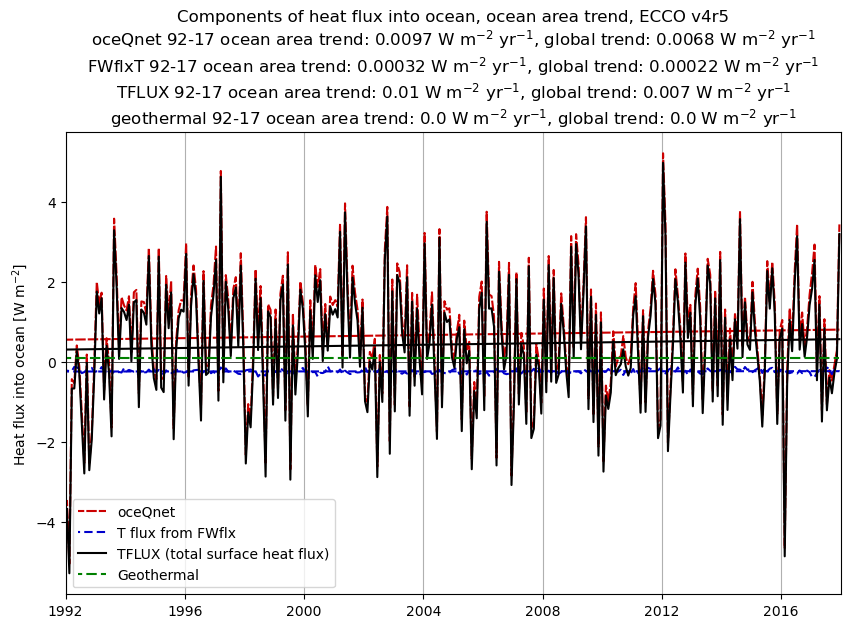

In [84]:
oceQnet_globmean_tmean = weighted_tmean(oceQnet_globmean_v4r5[:-24],delta_t_v4r5[:-24])
FWflxT_globmean_tmean = weighted_tmean(FWflxT_globmean_v4r5[:-24],delta_t_v4r5[:-24])
geoflx_globmean_tmean = weighted_tmean(geoflx_globmean_v4r5[:-24],delta_t_v4r5[:-24])
TFLUX_globmean_tmean = weighted_tmean(TFLUX_globmean_v4r5[:-24],delta_t_v4r5[:-24])

oceQnet_globmean_v4r5_noseas = \
            seasonal_cycle_harmonics(oceQnet_globmean_v4r5[:-24].values,ds_v4r5.time[:-24].values,num_harmonics=4)
FWflxT_globmean_v4r5_noseas = \
            seasonal_cycle_harmonics(FWflxT_globmean_v4r5[:-24].values,ds_v4r5.time[:-24].values,num_harmonics=4)
TFLUX_globmean_v4r5_noseas = \
            seasonal_cycle_harmonics(TFLUX_globmean_v4r5[:-24].values,ds_v4r5.time[:-24].values,num_harmonics=4)
trend_normalization = (delta_t_v4r5[:-24].sum('time')/len(delta_t_v4r5[:-24])).values
oceQnet_globmean_v4r5_trendperyr,oceQnet_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*oceQnet_globmean_v4r5)[:-24].values,delta_dim=1/12,output_trendline=True)
oceQnet_globmean_v4r5_trendperyr = oceQnet_globmean_v4r5_trendperyr/trend_normalization
oceQnet_globmean_v4r5_trendline = oceQnet_globmean_v4r5_trendline/trend_normalization
FWflxT_globmean_v4r5_trendperyr,FWflxT_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*FWflxT_globmean_v4r5)[:-24].values,delta_dim=1/12,output_trendline=True)
FWflxT_globmean_v4r5_trendperyr = FWflxT_globmean_v4r5_trendperyr/trend_normalization
FWflxT_globmean_v4r5_trendline = FWflxT_globmean_v4r5_trendline/trend_normalization
TFLUX_globmean_v4r5_trendperyr,TFLUX_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*TFLUX_globmean_v4r5)[:-24].values,delta_dim=1/12,output_trendline=True)
TFLUX_globmean_v4r5_trendperyr = TFLUX_globmean_v4r5_trendperyr/trend_normalization
TFLUX_globmean_v4r5_trendline = TFLUX_globmean_v4r5_trendline/trend_normalization
geoflx_globmean_v4r5_trendperyr,geoflx_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*geoflx_globmean_v4r5)[:-24].values,delta_dim=1/12,output_trendline=True)
geoflx_globmean_v4r5_trendperyr = geoflx_globmean_v4r5_trendperyr/trend_normalization
geoflx_globmean_v4r5_trendline = geoflx_globmean_v4r5_trendline/trend_normalization

fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
ax.plot(ds_v4r5.time[:-24].values,oceQnet_globmean_v4r5_noseas + oceQnet_globmean_tmean.values,\
                color=(.8,0,0),linestyle=(2,(5,1)),label='oceQnet')
h, = ax.plot(ds_v4r5.time[:-24].values,oceQnet_globmean_v4r5_trendline,\
                color=(.8,0,0),linestyle=(2,(5,1)),label='oceQnet')
handles.append(h)
ax.plot(ds_v4r5.time[:-24].values,FWflxT_globmean_v4r5_noseas + FWflxT_globmean_tmean.values,\
                color=(0,0,.8),linestyle=(3,(4,2)),label='T flux from FWflx')
h, = ax.plot(ds_v4r5.time[:-24].values,FWflxT_globmean_v4r5_trendline,\
                color=(0,0,.8),linestyle=(3,(4,2)),label='T flux from FWflx')
handles.append(h)
ax.plot(ds_v4r5.time[:-24].values,TFLUX_globmean_v4r5_noseas + TFLUX_globmean_tmean.values,\
                color=(0,0,0),label='TFLUX (total surface heat flux)')
h, = ax.plot(ds_v4r5.time[:-24].values,TFLUX_globmean_v4r5_trendline,\
                color=(0,0,0),label='TFLUX (total surface heat flux)')
handles.append(h)
h, = ax.plot(ds_v4r5.time[:-24].values,geoflx_globmean_v4r5_trendline,\
                color=(0,.5,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Components of heat flux into ocean, ocean area trend, ECCO v4r5\n'\
             +'oceQnet 92-17 ocean area trend: '+str(.0001*np.round(oceQnet_globmean_v4r5_trendperyr[0]/.0001))[:6]+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.0001*np.round(ratio_ocean_global_area*oceQnet_globmean_v4r5_trendperyr[0]/.0001))[:6]+' W m$^{-2}$ yr$^{-1}$\n'\
             +'FWflxT 92-17 ocean area trend: '+str(.00001*np.round(FWflxT_globmean_v4r5_trendperyr[0]/.00001))[:7]+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.00001*np.round(ratio_ocean_global_area*FWflxT_globmean_v4r5_trendperyr[0]/.00001))[:7]\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'TFLUX 92-17 ocean area trend: '+str(.0001*np.round(TFLUX_globmean_v4r5_trendperyr[0]/.0001))+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.0001*np.round(ratio_ocean_global_area*TFLUX_globmean_v4r5_trendperyr[0]/.0001))[:6]+' W m$^{-2}$ yr$^{-1}$\n'\
             +'geothermal 92-17 ocean area trend: '+str(.0001*np.round(geoflx_globmean_v4r5_trendperyr[0]/.0001))+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.0001*np.round(ratio_ocean_global_area*geoflx_globmean_v4r5_trendperyr[0]/.0001))+' W m$^{-2}$ yr$^{-1}$')
plt.legend(handles=handles)
plt.savefig(join(figures_dir,'Forcing_fluxes_globmean_noseas_trend_ECCOv4r5_1992_2017.png'))
plt.show()

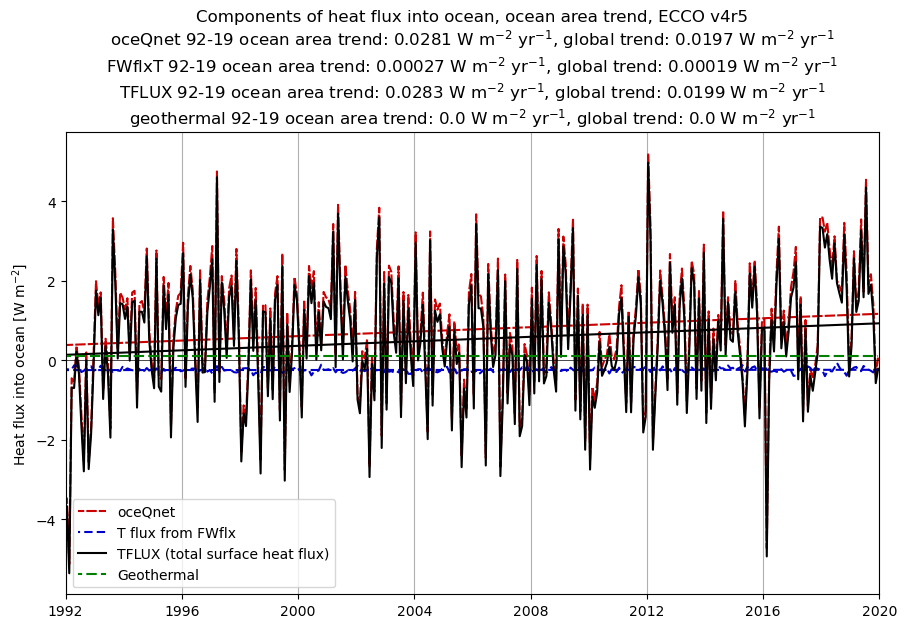

In [85]:
oceQnet_globmean_tmean_v4r5 = weighted_tmean(oceQnet_globmean_v4r5,delta_t_v4r5)
FWflxT_globmean_tmean_v4r5 = weighted_tmean(FWflxT_globmean_v4r5,delta_t_v4r5)
geoflx_globmean_tmean_v4r5 = weighted_tmean(geoflx_globmean_v4r5,delta_t_v4r5)
TFLUX_globmean_tmean_v4r5 = weighted_tmean(TFLUX_globmean_v4r5,delta_t_v4r5)

oceQnet_globmean_v4r5_noseas = \
            seasonal_cycle_harmonics(oceQnet_globmean_v4r5.values,ds_v4r5.time.values,num_harmonics=4)
FWflxT_globmean_v4r5_noseas = \
            seasonal_cycle_harmonics(FWflxT_globmean_v4r5.values,ds_v4r5.time.values,num_harmonics=4)
TFLUX_globmean_v4r5_noseas = \
            seasonal_cycle_harmonics(TFLUX_globmean_v4r5.values,ds_v4r5.time.values,num_harmonics=4)
trend_normalization = (delta_t_v4r5.sum('time')/len(delta_t_v4r5)).values
oceQnet_globmean_v4r5_trendperyr,oceQnet_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*oceQnet_globmean_v4r5).values,delta_dim=1/12,output_trendline=True)
oceQnet_globmean_v4r5_trendperyr = oceQnet_globmean_v4r5_trendperyr/trend_normalization
oceQnet_globmean_v4r5_trendline = oceQnet_globmean_v4r5_trendline/trend_normalization
FWflxT_globmean_v4r5_trendperyr,FWflxT_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*FWflxT_globmean_v4r5).values,delta_dim=1/12,output_trendline=True)
FWflxT_globmean_v4r5_trendperyr = FWflxT_globmean_v4r5_trendperyr/trend_normalization
FWflxT_globmean_v4r5_trendline = FWflxT_globmean_v4r5_trendline/trend_normalization
TFLUX_globmean_v4r5_trendperyr,TFLUX_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*TFLUX_globmean_v4r5).values,delta_dim=1/12,output_trendline=True)
TFLUX_globmean_v4r5_trendperyr = TFLUX_globmean_v4r5_trendperyr/trend_normalization
TFLUX_globmean_v4r5_trendline = TFLUX_globmean_v4r5_trendline/trend_normalization
geoflx_globmean_v4r5_trendperyr,geoflx_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*geoflx_globmean_v4r5).values,delta_dim=1/12,output_trendline=True)
geoflx_globmean_v4r5_trendperyr = geoflx_globmean_v4r5_trendperyr/trend_normalization
geoflx_globmean_v4r5_trendline = geoflx_globmean_v4r5_trendline/trend_normalization

fig,ax = plt.subplots(1,1,figsize=(10.5,6))
handles = []
ax.plot(ds_v4r5.time.values,oceQnet_globmean_v4r5_noseas + oceQnet_globmean_tmean_v4r5.values,\
                color=(.8,0,0),linestyle=(2,(5,1)),label='oceQnet')
h, = ax.plot(ds_v4r5.time.values,oceQnet_globmean_v4r5_trendline,\
                color=(.8,0,0),linestyle=(2,(5,1)),label='oceQnet')
handles.append(h)
ax.plot(ds_v4r5.time.values,FWflxT_globmean_v4r5_noseas + FWflxT_globmean_tmean_v4r5.values,\
                color=(0,0,.8),linestyle=(3,(4,2)),label='T flux from FWflx')
h, = ax.plot(ds_v4r5.time.values,FWflxT_globmean_v4r5_trendline,\
                color=(0,0,.8),linestyle=(3,(4,2)),label='T flux from FWflx')
handles.append(h)
ax.plot(ds_v4r5.time.values,TFLUX_globmean_v4r5_noseas + TFLUX_globmean_tmean_v4r5.values,\
                color=(0,0,0),label='TFLUX (total surface heat flux)')
h, = ax.plot(ds_v4r5.time.values,TFLUX_globmean_v4r5_trendline,\
                color=(0,0,0),label='TFLUX (total surface heat flux)')
handles.append(h)
h, = ax.plot(ds_v4r5.time.values,geoflx_globmean_v4r5_trendline,\
                color=(0,.5,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Components of heat flux into ocean, ocean area trend, ECCO v4r5\n'\
             +'oceQnet 92-19 ocean area trend: '+str(.0001*np.round(oceQnet_globmean_v4r5_trendperyr[0]/.0001))[:6]+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.0001*np.round(ratio_ocean_global_area*oceQnet_globmean_v4r5_trendperyr[0]/.0001))[:6]\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'FWflxT 92-19 ocean area trend: '+str(.00001*np.round(FWflxT_globmean_v4r5_trendperyr[0]/.00001))[:7]+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.00001*np.round(ratio_ocean_global_area*FWflxT_globmean_v4r5_trendperyr[0]/.00001))[:7]\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'TFLUX 92-19 ocean area trend: '+str(.0001*np.round(TFLUX_globmean_v4r5_trendperyr[0]/.0001))[:6]+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.0001*np.round(ratio_ocean_global_area*TFLUX_globmean_v4r5_trendperyr[0]/.0001))[:6]+' W m$^{-2}$ yr$^{-1}$\n'\
             +'geothermal 92-19 ocean area trend: '+str(.0001*np.round(geoflx_globmean_v4r5_trendperyr[0]/.0001))+' W m$^{-2}$ yr$^{-1}$,'\
             +' global trend: '+str(.0001*np.round(ratio_ocean_global_area*geoflx_globmean_v4r5_trendperyr[0]/.0001))+' W m$^{-2}$ yr$^{-1}$')
plt.legend(handles=handles)
plt.savefig(join(figures_dir,'Forcing_fluxes_globmean_noseas_trend_ECCOv4r5_1992_2019.png'))
plt.show()